In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from afqinsight.datasets import AFQDataset
from neurocombat_sklearn import CombatModel
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer



In [3]:
# Load data as AFQ Dataset and filter participants who did not pass qc

data_path = "/home/users/ethanroy/vanderbilt_colab/data/"

# Select columns to protect during ComBat
protect_cols = ['Age','WJ_reading_sum_w']

def load_data_notf(protect_cols):
    
    ## in subjects.csv, combined subject-session IDs need to be in subject, the pure subject ID should be in subjectID
    afq_dataset = AFQDataset.from_files(
        fn_nodes=f"{data_path}combined_tract_profiles_rev.csv",
        fn_subjects=f"{data_path}subjects.csv",
        dwi_metrics=["dti_fa", "dti_md", "dti_rd","dti_ad"],
        index_col="subject",
        target_cols=["Age",'WJ_reading_sum_w', "rating", "scanner","scanner2","sessionID",'subjectID'],
        label_encode_cols=["scanner"]
    )
    
    qc = afq_dataset.y[:, 2]

    covars = pd.DataFrame(afq_dataset.y[(qc>0)],columns=afq_dataset.target_cols)
    covars['sessionID'] = covars['sessionID'].str[-1].astype(int)
    na_protect = covars[protect_cols].isna().any(axis=1)

    y = afq_dataset.y[:, 0][(qc>0)]
    site = afq_dataset.y[:, 3][(qc>0)]
    X = afq_dataset.X[(qc>0)]
    subs = np.array(afq_dataset.subjects)[(qc>0)]
    subs = list(subs[~na_protect])
    
    return X[~na_protect], y[~na_protect], site[~na_protect], covars[~na_protect], subs, afq_dataset

X, y, site, covars, subs, dataset = load_data_notf(protect_cols)

In [4]:
df = pd.DataFrame(covars, columns=dataset.target_cols, index=subs)



In [5]:
cols = [i[0]+'-'+i[1]+'-'+str(i[2]) for i in dataset.feature_names]


df_nodes = pd.DataFrame(data=X, index=df.index)
df_nodes.columns=cols

df_nodes = df_nodes.reset_index().rename(columns={'index':'subjectID'})


# pd.concat([covars,df_nodes],axis=1).to_csv(f'{data_path}tract_profiles_filtered_wide.csv')

In [6]:
covars.groupby(['scanner','sessionID']).count()


Age  WJ_reading_sum_w  rating  scanner2  subjectID
scanner sessionID                                                    
0       1           57                57      57        57         57
        2           45                45      45        45         45
        3           20                20      20        20         20
        4           30                30      30        30         30
1       1           57                57      57        57         57
        2           89                89      89        89         89
        3           89                89      89        89         89
        4           33                33      33        33         33
2       1           80                80      80        80         80
        2           28                28      28        28         28
        3           18                18      18        18         18
        4           11                11      11        11         11

### 5-Fold CV To Generate Harmonized Profiles

In [7]:
# Define the number of folds for cross-validation
num_folds = 5

# setup splits so all of a participants observations are in the same split
groups = np.array(subs)
group_kfold = GroupKFold(n_splits=num_folds)
group_kfold.get_n_splits(X, y, groups)



5

### Group 5-Fold

In [8]:
# init empty array for harmonized data
X_harmonized_groups = np.zeros((0, X.shape[1]))  

# loop through our train/test splits and harmonize
for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups)):

    # Set up train/test splits for ComBat
    X_train, X_test = X[train_index], X[test_index]
    site_train, site_test = site[train_index], site[test_index]
    covars_train, covars_test = covars.iloc[train_index], covars.iloc[test_index]
    
    # Set up model
    combat = CombatModel()
    
    imputer = SimpleImputer(strategy="median")

    # impute any missing data
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # fit model
    X_train_combat = combat.fit_transform(X_train, site_train[:, None],
                                          covars_train[['sessionID']], covars_train[protect_cols])
    # generate harmonized data for test set
    X_test_combat = combat.transform(X_test, site_test[:, None], 
                                     covars_test[['sessionID']], covars_test[protect_cols])
    
    # build out harmonized data for each test set
    X_harmonized_groups = np.concatenate((X_harmonized_groups, X_test_combat))

/Users/ethanroy/miniconda3/envs/insight_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/ethanroy/miniconda3/envs/insight_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/ethanroy/miniconda3/envs/insight_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/ethanroy/miniconda3/envs/insight_env/lib/python3.10/site-packages/sklearn/preprocess

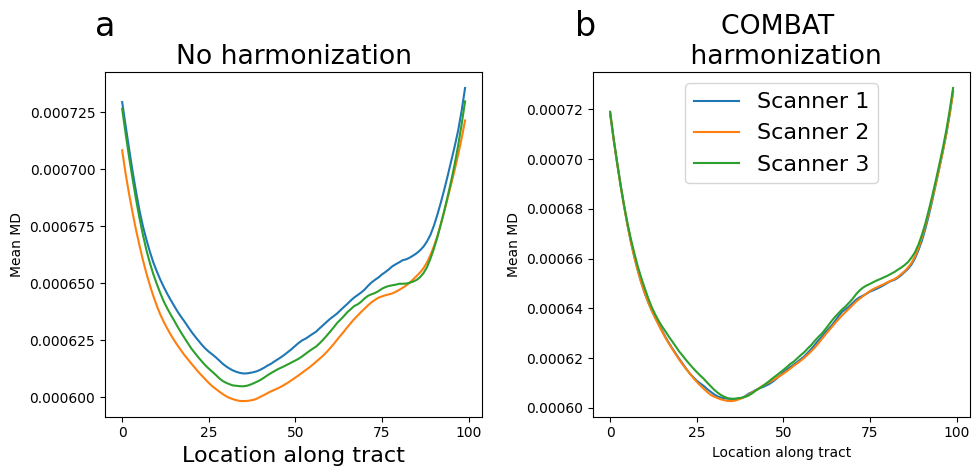

In [9]:
# Compare the raw harmonized MD profile for the left arcuate

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.rcParams['font.size'] = 16

fig.text(0.1, 0.96, 'a', ha='left', va='top', fontsize=24)
fig.text(0.58, 0.96, 'b', ha='left', va='top', fontsize=24)

ax[0].set_title("No harmonization")
ax[0].plot(np.array([np.mean(X[site == scan, 4400:4500], 0) for scan in np.unique(site)]).T,
            label=["Scanner 1", "Scanner 2", "Scanner 3"])
ax[0].set_xlabel("Location along tract", fontsize=16)
ax[0].set_ylabel("Mean MD")
ax[1].set_title("COMBAT \n harmonization")
ax[1].plot(np.array([np.mean(X_harmonized_groups[site == scan, 4400:4500], 0) for scan in np.unique(site)]).T,
           label=["Scanner 1", "Scanner 2", "Scanner 3"])
ax[1].set_xlabel("Location along tract")
ax[1].set_ylabel("Mean MD")
plt.legend()
plt.tight_layout()

### Save Harmonized Profiles

In [10]:
# get harmonized data back into afq-output long format

df_nodes = pd.DataFrame(data=X_harmonized_groups, index=df.index)
df_nodes.columns=cols

df_nodes = df_nodes.reset_index().rename(columns={'index':'subjectID'})
df_nodes_long = df_nodes.melt(id_vars=['subjectID'])

df_nodes_long[['metric','tractID','nodeID']] = df_nodes_long['variable'].str.split('-', expand=True)
df_nodes_long['nodeID'] = df_nodes_long['nodeID'].astype(int)

del df_nodes_long['variable']

df_nodes_long = df_nodes_long.pivot(index=['subjectID','tractID','nodeID'],
                                    columns='metric',
                                    values='value').reset_index()

df_nodes_long.to_csv(f'{data_path}full_profile_harm_df_rev.csv')
